In [1]:
import logging
logger = logging.getLogger(__name__)
for system in ['h5py._conv', 'matplotlib', 'PIL']:
     logging.getLogger(system).setLevel(logging.WARNING)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np
from dedalus import public as de

In [2]:
nz = 128
IC = 'LBVP' # 'LBVP' -> compute LBVP, 'linear' (or else) -> use linear ICs
verbose = True
q_surface = 0.5

In [3]:
Lx = Ly = 10
Lz = 1
Rayleigh = 1e6 #1e4
Prandtl = 1
Prandtlm = 1

α = 3
β = 1.2 #1.201
γ = 0.19
tau_Vallis = 5e-5
ΔT = -1

The non-dimensional tau timescale, relative to the thermal time, is:
\begin{equation}
    \tau = \tau_d \frac{\kappa}{H^2} = 5\times10^{-5}
\end{equation}
with $\tau_d$ the dimensional condensation time (Vallis et al 2019).

In buoyancy timescales,
\begin{align}
    \tau &= \tau_d \sqrt{\alpha \Delta T g} \\
    &= \tau_d \sqrt{\frac{\alpha \Delta T g H^4}{\kappa^2}} \frac{\kappa}{H^2} \\
    & = \sqrt{Ra Pr} \left(\tau_d \frac{\kappa}{H^2}\right) \\
    & = \sqrt{Ra Pr} \times \left(5\times10^{-5}\right) 
\end{align}
or, given $Ra \approx 10^{6}$
\begin{equation}
    \tau \approx 5 \times 10^{-3}
\end{equation}
This indicates that, in buoyancy time units, condensation is rapid compared to buoyant times.  Maybe too rapid.

Meanwhile, the quantity $P \tau$ is:
\begin{align}
    P \tau &= \frac{\sqrt{Ra Pr}}{\sqrt{Ra Pr}} \times \left(5\times10^{-5}\right) \\
    & = 5\times10^{-5}
\end{align}
Things probably don't get better if we multiply all terms through by P$\ldots$

In [4]:
P = (Rayleigh * Prandtl)**(-1/2)         #  diffusion on buoyancy
S = (Rayleigh * Prandtlm)**(-1/2)        #  diffusion on moisture
tau = 3/8 #tau_Vallis*(Rayleigh*Prandtl)**(1/2)     #  condensation timescale
print('tau = {:.2g}'.format(tau))

tau = 0.38


In [5]:
# Create bases and domain
coords = de.CartesianCoordinates('x', 'y', 'z')
dist = de.Distributor(coords, dtype=np.float64)
dealias = 2
zb = de.ChebyshevT(coords.coords[2], size=nz, bounds=(0, Lz), dealias=dealias)
z = zb.local_grid(1)

b = dist.Field(name='b', bases=zb)
q = dist.Field(name='q', bases=zb)

τb1 = dist.Field(name='τb1')
τb2 = dist.Field(name='τb2')
τq1 = dist.Field(name='τq1')
τq2 = dist.Field(name='τq2')

zb1 = zb.clone_with(a=zb.a+1, b=zb.b+1)
zb2 = zb.clone_with(a=zb.a+2, b=zb.b+2)
lift1 = lambda A, n: de.Lift(A, zb1, n)
lift = lambda A, n: de.Lift(A, zb2, n)

ex, ey, ez = coords.unit_vector_fields(dist)

k = 1e2 #3 #1e5 # cutoff for tanh
H = lambda A: 0.5*(1+np.tanh(k*A))

z_grid = dist.Field(name='z_grid', bases=zb)
z_grid['g'] = z

temp = b - β*z_grid
temp.name = 'T'

qs = np.exp(α*temp)
rh = q*np.exp(-α*temp)

In [6]:
def plot_solution(title=None, mask=None, linestyle=None, ax=None):
    T_sol = temp.evaluate()
    rh_sol = rh.evaluate()

    T_sol.change_scales(1)
    rh_sol.change_scales(1)
    b.change_scales(1)
    q.change_scales(1)

    if mask is None:
        mask = np.ones_like(z, dtype=bool)
    if ax is None:
        fig, ax = plt.subplots(ncols=2)
        markup = True
    else:
        for axi in ax:
            axi.set_prop_cycle(None)
        markup = False
    ax[0].plot(b['g'][mask],z[mask], label='$b$', linestyle=linestyle)
    ax[0].plot(γ*q['g'][mask],z[mask], label='$\gamma q$', linestyle=linestyle)
    ax[0].plot(b['g'][mask]+γ*q['g'][mask],z[mask], label='$b+\gamma q$', linestyle=linestyle)

    ax[1].plot(T_sol['g'][mask],z[mask], label='$T$', linestyle=linestyle)
    ax[1].plot(q['g'][mask],z[mask], label='$q$', linestyle=linestyle)
    ax[1].plot(rh_sol['g'][mask],z[mask], label='$r_h$', linestyle=linestyle)
    
    if markup:
        ax[1].legend()
        ax[0].legend()
        ax[0].set_ylabel('z')
        if title:
            ax[0].set_title(title)
    return ax

2022-10-05 15:27:19,729 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+01/s
b: 1.4e-17 -- 0.2
q: 0.5 -- 0.05


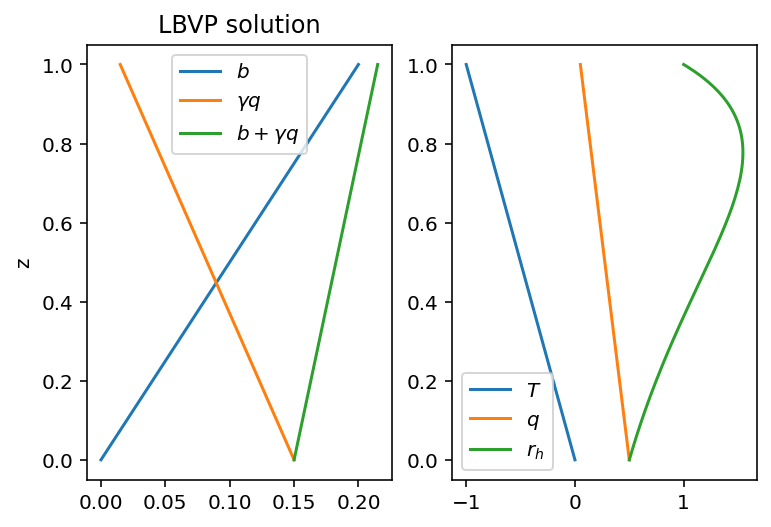

In [7]:
if IC == 'LBVP':
    dt = lambda A: 0*A
    # Stable linear solution as an intial guess
    problem = de.LBVP([b, q, τb1, τb2, τq1, τq2], namespace=locals())
    problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) = 0')
    problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) = 0')
    problem.add_equation('b(z=0) = 0')
    problem.add_equation('b(z=Lz) = β + ΔT') # technically β*Lz
    problem.add_equation('q(z=0) = q_surface')
    problem.add_equation('q(z=Lz) = np.exp(α*ΔT)')
    solver = problem.build_solver()
    solver.solve()
else:
    b['g'] = (β + ΔT)*z
    q['g'] = (1-z+np.exp(α*ΔT))
    
print('b: {:.2g} -- {:.2g}'.format(b(z=0).evaluate()['g'][0,0,0], b(z=Lz).evaluate()['g'][0,0,0]))
print('q: {:.2g} -- {:.2g}'.format(q(z=0).evaluate()['g'][0,0,0], q(z=Lz).evaluate()['g'][0,0,0]))

if verbose:
    plot_solution(title='LBVP solution')

In [8]:
dt = lambda A: 0*A

# Stable nonlinear solution
problem = de.NLBVP([b, q, τb1, τb2, τq1, τq2], namespace=locals())
problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) = γ*H(q-qs)*(q-qs)/tau')
problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) = - H(q-qs)*(q-qs)/tau')
problem.add_equation('b(z=0) = 0')
problem.add_equation('b(z=Lz) = β + ΔT') # technically β*Lz
problem.add_equation('q(z=0) = q_surface*qs(z=0)')
problem.add_equation('q(z=Lz) = np.exp(α*ΔT)')

In [9]:
for system in ['subsystems']:
     logging.getLogger(system).setLevel(logging.WARNING)

# Relax on k
for k in [1e1, 1e3, 1e5]:
    solver = problem.build_solver(ncc_cutoff=1e-6)
    pert_norm = np.inf
    tol = 1e-2
    while pert_norm > tol:
        solver.newton_iteration()
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info("k = {:.0g}, L2 err = {:.1g}".format(k, pert_norm))

2022-10-05 15:27:25,737 __main__ 0/1 INFO :: k = 1e+01, L2 err = 0.06
2022-10-05 15:27:27,312 __main__ 0/1 INFO :: k = 1e+01, L2 err = 0.005
2022-10-05 15:27:28,842 __main__ 0/1 INFO :: k = 1e+03, L2 err = 0.004
2022-10-05 15:27:30,282 __main__ 0/1 INFO :: k = 1e+05, L2 err = 0.002


array([<AxesSubplot:title={'center':'NLBVP solution'}, ylabel='z'>,
       <AxesSubplot:>], dtype=object)

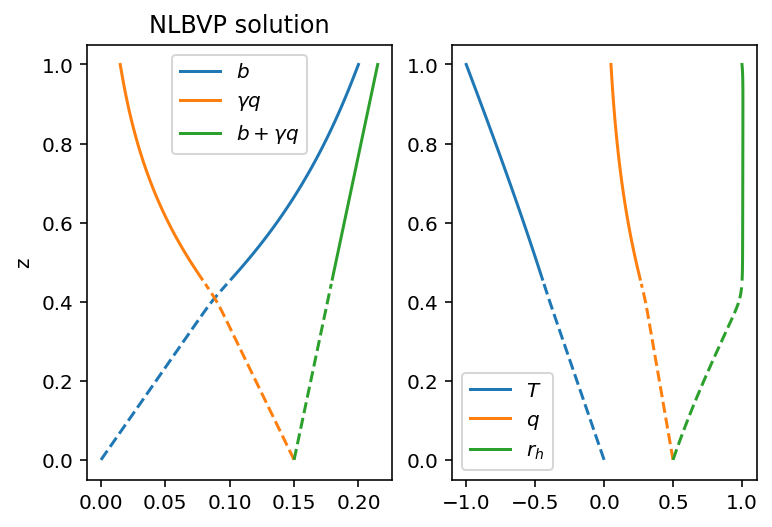

In [10]:
value = rh.evaluate()
value.change_scales(1)
mask = (value['g'] >= 1)
ax = plot_solution(title='NLBVP solution', mask=mask, linestyle='solid')
mask = (value['g'] < 1)
plot_solution(title='NLBVP solution', mask=mask, linestyle='dashed', ax=ax)

This does not agree with Vallis et al 2019, Fig 2:
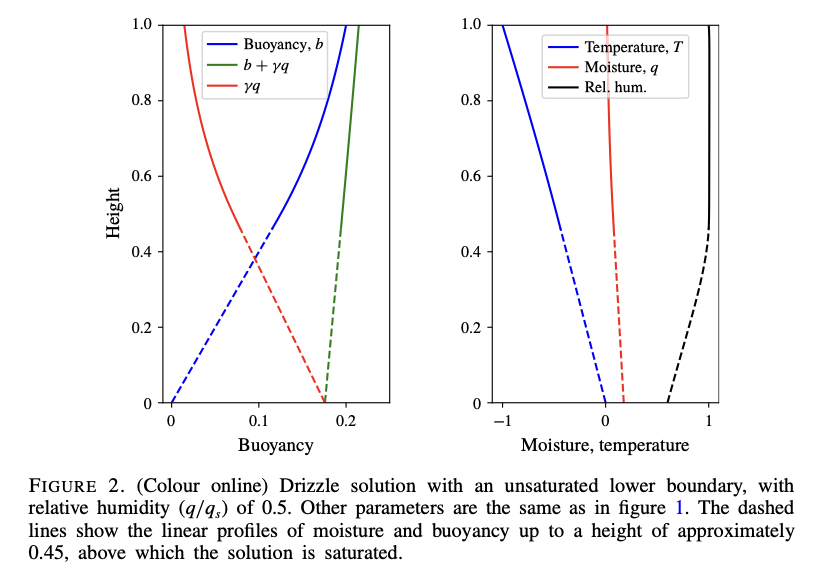

Here, we used $(q/q_s)$=0.5 as in the caption, rather than 0.6 as in the text, but that makes no meaningful difference to the final result and degree of disagreement (interestingly, 0.5 is more difficult to converge than 0.6).  The transition from unsaturated to saturated in our solution is much sharper and occurs at a lower value of $z\approx0.3$ rather than $z\approx0.45$ as seen in Vallis.